On s'intéresse ici à la prédiction de l'intention (`intent`) d'un utilisateur dans un système de dialogue. Pour chaque ennoncé, il faut prédire la catégorie de l'ennoncé parmis les 7 intentions spécifiquse au domaine du corpus SNIPS : ajouter un élément à une playlist, réserver un réstaurent, obtenir la météo, écouter de la musique, donner son avis sur un livre, rechercher une oeuvre artistique ou obtenir des horaires de cinéma.

Le corpus est divisé en 3 parties : train, valid et test. Il contient un fichier `seq.in` avec un ennoncé par ligne, `seq.out` avec des étiquettes BIO pour représenter les entités liées aux intentions (non-utilisé ici) et un fichier `label` contenant les intentions.

In [ ]:
%%bash

curl -sO https://pageperso.lis-lab.fr/benoit.favre/files/snips-nlu.zip
unzip -o snips-nlu.zip
sort snips-nlu/train/label | uniq -c

Archive:  snips-nlu.zip
   creating: snips-nlu/
   creating: snips-nlu/train/
  inflating: snips-nlu/train/seq.in  
  inflating: snips-nlu/train/seq.out  
  inflating: snips-nlu/train/label   
   creating: snips-nlu/test/
  inflating: snips-nlu/test/seq.in   
  inflating: snips-nlu/test/seq.out  
  inflating: snips-nlu/test/label    
   creating: snips-nlu/valid/
  inflating: snips-nlu/valid/seq.in  
  inflating: snips-nlu/valid/seq.out  
  inflating: snips-nlu/valid/label   
   1818 AddToPlaylist
   1881 BookRestaurant
   1896 GetWeather
   1914 PlayMusic
   1876 RateBook
   1847 SearchCreativeWork
   1852 SearchScreeningEvent


Commençons par charger les énnoncés et étiquettes correspondant. 

In [ ]:
def load_instances(text_filename, label_filename):
  with open(label_filename) as fp:
    labels = [line.strip() for line in fp]
  with open(text_filename) as fp:
    texts = [line.strip() for line in fp]
  return texts, labels

train_texts, train_labels = load_instances('snips-nlu/train/seq.in', 'snips-nlu/train/label')
valid_texts, valid_labels = load_instances('snips-nlu/valid/seq.in', 'snips-nlu/valid/label')
test_texts, test_labels = load_instances('snips-nlu/test/seq.in', 'snips-nlu/test/label')

for label, text in zip(train_labels[:10], train_texts[:10]):
  print(text, '=>', label)

listen to westbam alumb allergic on google music => PlayMusic
add step to me to the 50 clásicos playlist => AddToPlaylist
i give this current textbook a rating value of 1 and a best rating of 6 => RateBook
play the song little robin redbreast => PlayMusic
please add iris dement to my playlist this is selena => AddToPlaylist
add slimm cutta calhoun to my this is prince playlist => AddToPlaylist
i want to listen to seventies music => PlayMusic
play a popular chant by brian epstein => PlayMusic
find fish story => SearchScreeningEvent
book a spot for 3 in mt => BookRestaurant


Il est intéressant d'afficher un histogramme des longueurs des textes pour voir quelle pourrait être une longueur maximale acceptable pour représenter les données sous forme de tenseurs. Par exemple, une longueur de 20 semble convenir pour la plus grande partie des données.

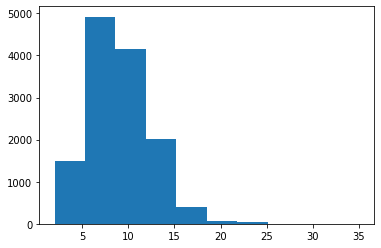

In [ ]:
from matplotlib import pyplot as plt
plt.hist([len(text.split()) for text in train_texts])
plt.show()

Il est temps d'import pytorch et de définir les classiques paramètres globaux des systèmes. Il faut noter que nous utilisons ici une grande taille de batch et l'accélérateur GPU (à activer sur colab) pour réduire les temps de traitements avec les modèles de type BERT.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

maxlen = 20
batch_size = 256
hidden_size = 128
embed_size = 128
device = torch.device('cuda')

BERT est un modèle issu de la partie encodeur d'un transformer, qui repose essentiellement sur l'accumulation de couches d'attention avec un encodage de la position. On peut trouver relativement facilement sur le web des [explications illustrées](http://jalammar.github.io/illustrated-transformer/) sur les détails du fonctionnement de BERT. Nous n'allons pas le réimplémenter, mais utiliser une implémentation créée par la stratup Hugging Face. Le [répository](https://github.com/huggingface/transformers) de Hugging Face contient une implémentation de diverses variantes de modèles fondés sur les transformers ainsi que des poids préentraînés correspondant.

Le modèle BERT fait une tokenization en sous-mots pour limiter le nombre de mots à traiter, et pour généraliser plus facilement sur les mots inconnus. Nous utiliserons cette tokenization pour toutes les exprériences. Le modèle BERT est très coûteux en temps de calcul et nous utiliserons une version plus petite, appellée [DistilBert](https://arxiv.org/abs/1910.01108), issue d'une "distillation" des poids du modèle BERT d'origine.

Il est a noter que le tokenizer divise les mots qu'il ne connait pas en sous-tokens dénotés par `##`, et qu'il faut ajouter un token en début de phrase et en fin de phrase pour la limiter (le modèle est capable de traiter plusieurs phrases).

In [ ]:
!pip -q install transformers
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def bert_text_to_ids(sentence):
  return torch.tensor(tokenizer.encode(sentence, add_special_tokens=True))

print(tokenizer.tokenize('i really like the band raspigaous.'))
print(bert_text_to_ids('i really like the band raspigaous.'))

     |████████████████████████████████| 450kB 8.1MB/s 
     |████████████████████████████████| 1.0MB 18.9MB/s 
     |████████████████████████████████| 870kB 46.0MB/s 


['i', 'really', 'like', 'the', 'band', 'ras', '##pi', '##ga', '##ous', '.']
tensor([  101,  1045,  2428,  2066,  1996,  2316, 20710,  8197,  3654,  3560,
         1012,   102])


Il faut maintenant créer des tenseurs avec les données de chaque sous-ensemble. BERT s'occupe de tokenizer et convertir les mots en identifiants, mais nous devons le faire pour les étiquettes. Nous en profitons pour imposer la longueur maximale et envoyer les tenseurs sur GPU.

In [ ]:
import collections
label_vocab = collections.defaultdict(lambda: len(label_vocab))

def prepare_texts(texts, labels):
  X = torch.LongTensor(len(texts), maxlen).fill_(tokenizer.pad_token_id)
  for i, text in enumerate(texts):
    indexed_tokens = bert_text_to_ids(text)
    length = min([maxlen, len(indexed_tokens)])
    X[i,:length] = indexed_tokens[:length]
  
  Y = torch.tensor([label_vocab[label] for label in labels]).long()
  return X.to(device), Y.to(device)

X_train, Y_train = prepare_texts(train_texts, train_labels)
X_valid, Y_valid = prepare_texts(valid_texts, valid_labels)
X_test, Y_test = prepare_texts(test_texts, test_labels)

print(X_train.shape)
print(X_train[:3])

torch.Size([13084, 20])
tensor([[  101,  4952,  2000,  2225,  3676,  2213,  2632, 25438, 27395,  2006,
          8224,  2189,   102,     0,     0,     0,     0,     0,     0,     0],
        [  101,  5587,  3357,  2000,  2033,  2000,  1996,  2753, 18856, 21369,
         13186,  2377,  9863,   102,     0,     0,     0,     0,     0,     0],
        [  101,  1045,  2507,  2023,  2783, 16432,  1037,  5790,  3643,  1997,
          1015,  1998,  1037,  2190,  5790,  1997,  1020,   102,     0,     0]],
       device='cuda:0')


Il s'agit maintenant de créer des datasets et générateurs de batches en utilisant l'approche classique en pytorch. 

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)
test_set = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

Le premier modèle est un RNN bidirectionnel à base de GRU très classique. Il commence par une couche d'embeddings initialisés aléatoirement, suivie d'une couche de GRU, suivi de dropout et d'une couche de décision. Nous utilisons le dernier état caché du RNN comme représentation donnée à la couche de décision, dont la forme de tenseur est (nombre de couches GRU, nombre de directions, taille de l'état caché). On en déduit une taille de couche cachée de $1\times 2 \times \text{hidden_size}$.

La fonction `forward` est très classique et nécessite juste de manipuler le dernier état caché du RNN pour qu'il ait comme forme (taille du batch, taille de l'état caché $\times$ directions $\times$ nombre de couches). Cette fonction prend en entrée un tenseur $x$ représentant un batch de taille (taille du batch, longueur maximale d'une phrase).

Il est toujours bien de vérifier que le tenseur renvoyé par l'inférence a pour forme (taille du batch, nombre de classes). 

In [ ]:
class RNNClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Embedding(tokenizer.vocab_size, embed_size, padding_idx=tokenizer.pad_token_id)
    self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.decision = nn.Linear(1 * 2 * hidden_size, len(label_vocab))
    self.to(device)
  
  def forward(self, x):
    embed = self.embed(x)
    output, hidden = self.rnn(embed) 
    drop = self.dropout(hidden.transpose(0, 1).reshape(x.shape[0], -1))
    return self.decision(drop)

rnn_model = RNNClassifier()
with torch.no_grad():
  print(rnn_model(X_train[:3]).shape)

torch.Size([3, 7])


La fonction de calcul des performances est classique. Elle utilise un critère d'entropie croisée (même loss qu'en entrînement), et calcule le taux de corrects du modèle.

In [ ]:
def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = num = correct = 0
    for x, y in loader:
      with torch.no_grad():
        y_scores = model(x)
        loss = criterion(y_scores, y)
        y_pred = torch.max(y_scores, 1)[1]
        correct += torch.sum(y_pred == y).item()
        total_loss += loss.item()
        num += len(y)
    return total_loss / num, correct / num

perf(rnn_model, valid_loader)

(0.008468323264803205, 0.19857142857142857)

La fonction d'apprentissage est elle aussi standard. Nous rendons toutefois le taux d'apprentissage (lr) paramètrable car le fine-tuning des paramètres de BERT avec Adam est instable si le taux d'apprentissage n'est pas plus bas que la valeur par défaut. Cette dernière marche très bien pour le RNN.  

In [ ]:
def fit(model, epochs, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        print(epoch, total_loss / num, *perf(model, valid_loader))

fit(rnn_model, 10)

0 0.0036398950714796774 0.0012371916323900222 0.9228571428571428
1 0.0006147358687244326 0.0004416057573897498 0.9685714285714285
2 0.000294292799488407 0.00038191310529197967 0.9742857142857143
3 0.00017935920034648262 0.00048675505710499625 0.9714285714285714
4 0.00011342661283729192 0.00033707269600459505 0.9785714285714285
5 7.167282334615134e-05 0.0003726449715239661 0.98
6 4.8101932827972085e-05 0.0003669663997633117 0.9785714285714285
7 3.383737552862071e-05 0.0005068811880690711 0.97
8 1.7471139894947022e-05 0.0004808847246957677 0.9757142857142858
9 1.0764472796864983e-05 0.0005608252036784377 0.9728571428571429


Le second modèle est basé sur DistilBERT. L'idée est de faire passer les entrées (tokens) à travers l'encodeur d'un transformer (BERT), d'en récupérer la représentation aggrégée sur toute la phrase (équivalent de l'état caché du RNN après le dernier mot) et de la passer à une couche de décision. Il faut faire attention à dimensionner cette dernière avec la taille de la représentation générée par BERT.

Dans la fonction forward, BERT nécessite un masque pour désigner les mots sur lesquels porte le mécanisme d'attention, sans quoi les représentations générées n'auront pas de sens. Le composant renvoie une représentation par mot et nous utilisons le max pooling pour aggréger ces représentations.

In [ ]:
from transformers import DistilBertModel

class BertClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
    self.decision = nn.Linear(self.bert.config.hidden_size, len(label_vocab))
    self.to(device)

  def forward(self, x):
    output = self.bert(x, attention_mask = (x != tokenizer.pad_token_id).long())
    return self.decision(torch.max(output[0], 1)[0])

bert_model = BertClassifier()
with torch.no_grad():
  print(bert_model(X_train[:3]).shape)

torch.Size([3, 7])


Étant donné la longeur de l'entraînement avec BERT, nous ne ferons que 5 époque avec un taux d'apprentissage de 0.00002.

In [ ]:
fit(bert_model, 5, lr=2e-5)

0 0.0033761404866984187 0.00047010838187166624 0.9742857142857143
1 0.0003032651369709627 0.00026615991656269344 0.9828571428571429
2 0.00015907464289849265 0.0001351036104772772 0.9942857142857143
3 0.00010973795065704707 0.00017267641478351184 0.9885714285714285
4 7.808252857147836e-05 0.00020353555413229124 0.9857142857142858


Les résultats obtenus peuvent être comparés à ceux de https://github.com/czhang99/Capsule-NLU. Normalement ils devraient pas être très loin de l'état de l'art sur ce corpus.

In [ ]:
print('RNN', *perf(rnn_model, test_loader))
print('BERT', *perf(bert_model, test_loader))

RNN 0.000596585784639631 0.9657142857142857
BERT 0.00025549729487725666 0.9757142857142858
